In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import models, layers, optimizers
from itertools import product
import tensorflow as tf

In [3]:
# Impostazioni per la stampa dei numeri
np.set_printoptions(precision=20, suppress=True)

# Caricamento dei dati
my_data = np.genfromtxt('ML-CUP24-TR.csv', delimiter=',')
X = my_data[:, 1:13]
y = my_data[:, 13:16]
print(X.shape, y.shape)

# Suddividi i dati in train (60%) e temp (40%) (HOLDOUT)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Suddividi temp in validation (20%) e test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalizza i dati
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train = scaler_X.transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

(250, 12) (250, 3)


In [5]:
# Funzione di attivazione RBF con TensorFlow
def rbf_activation(x, centers, gamma=1.0):
    # Calcola la distanza euclidea tra l'input e i centri
    diff = x[:, np.newaxis, :] - centers
    dist_sq = tf.reduce_sum(tf.square(diff), axis=-1)  # Usa tf.reduce_sum invece di np.sum
    return tf.exp(-gamma * dist_sq)

# Creare il modello
def build_rbf_model(input_dim, output_dim, n_centers=10, gamma=1.0):
    model = models.Sequential()

    # Layer di input: utilizza 'shape' invece di 'input_dim'
    model.add(layers.InputLayer(shape=(input_dim,)))

    # Layer nascosta con attivazione RBF (calcola distanza dal centro)
    centers = tf.Variable(np.random.randn(n_centers, input_dim), dtype=tf.float32)  # Centri randomici
    model.add(layers.Lambda(lambda x: rbf_activation(x, centers, gamma)))

    # Layer di output con una dimensione pari al numero di target (3 in questo caso: x, y, z)
    model.add(layers.Dense(output_dim))

    return model

## Test 1:

In [27]:
# Funzione per eseguire la Grid Search
def grid_search(X_train, y_train, X_val, y_val, X_test, y_test, param_grid, epochs=50):
    results = []
    
    for params in product(*param_grid.values()):
        # Costruire il modello con i parametri correnti
        param_dict = dict(zip(param_grid.keys(), params))
        print(f"Testing parameters: {param_dict}")
        
        model = build_rbf_model(
            input_dim=X_train.shape[1],
            output_dim=y_train.shape[1],
            n_centers=param_dict["n_centers"],
            gamma=param_dict["gamma"]
        )
        
        # Configurare l'ottimizzatore
        optimizer = param_dict["optimizer"](learning_rate=param_dict["learning_rate"])
        
        # Passare il valore di batch_size
        batch_size = param_dict["batch_size"]
        
        # Compilare e allenare il modello
        model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Ottenere i valori di loss per train e validation
        val_loss = history.history['val_loss'][-1]
        
        # Valutare il modello sui dati di test
        test_loss, test_mse = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}")
        
        # Calcolare l'MSE sui dati di test
        y_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        
        print(f"Test MSE: {test_mse:.4f}")
        
        # Salvare i risultati
        results.append({
            **param_dict,
            "test_loss": test_loss,
            "val_loss": val_loss,
            "test_mse": test_mse
        })
    
    # Salvare i risultati in un file CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv("TestsData/grid_search_results.csv", index=False)
    print("Grid Search completata. Risultati salvati in grid_search_results.csv")

# Definizione della griglia dei parametri
param_grid = {
    "n_centers": [5, 10, 15],  # Numero di centri
    "gamma": [0.1, 0.5, 1.0],  # Gamma per RBF
    "optimizer": [optimizers.Adam, optimizers.SGD],  # Ottimizzatori
    "learning_rate": [0.001, 0.01],  # Learning rate
    "batch_size": [32, 64, 128]  # Diverse batch size
}

# Eseguire la Grid Search
if __name__ == "__main__":
    grid_search(X_train, y_train, X_val, y_val, X_test, y_test, param_grid)

Testing parameters: {'n_centers': 5, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001, 'batch_size': 32}
Test Loss: 0.9017
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test MSE: 0.9017
Testing parameters: {'n_centers': 5, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001, 'batch_size': 64}
Test Loss: 0.8891
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test MSE: 0.8891
Testing parameters: {'n_centers': 5, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001, 'batch_size': 128}
Test Loss: 0.8461
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test MSE: 0.8461
Testing parameters: {'n_centers': 5, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.01, 'batch_size': 32}
Test Loss: 0.6904
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test MSE: 0.6904
Testing parameters: {'n_centers': 5, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_

### Analisi result1:
Migliori valori con cui si raggiungono i migliori risultati:
- Numero di centri alto (10-15)
- Gamma basso (0.1)
- Learning rate alto (0.01)
- Batch size (indifferente - tendente basso 32)
- Adam è il migliore in assoluto

## Test 2:

- N centri: aggiungo 20 tolgo 5
- Gamma: tolgo 0.5 e 1 e aggiungo 0.001 e 0.01

In [35]:
# Funzione per eseguire la Grid Search
def grid_search(X_train, y_train, X_val, y_val, X_test, y_test, param_grid, epochs=50):
    results = []
    
    for params in product(*param_grid.values()):
        # Costruire il modello con i parametri correnti
        param_dict = dict(zip(param_grid.keys(), params))
        print(f"Testing parameters: {param_dict}")
        
        model = build_rbf_model(
            input_dim=X_train.shape[1],
            output_dim=y_train.shape[1],
            n_centers=param_dict["n_centers"],
            gamma=param_dict["gamma"]
        )
        
        # Configurare l'ottimizzatore
        optimizer = param_dict["optimizer"](learning_rate=param_dict["learning_rate"])
        
        # Passare il valore di batch_size
        batch_size = param_dict["batch_size"]
        
        # Compilare e allenare il modello
        model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Ottenere i valori di loss per train e validation
        val_loss = history.history['val_loss'][-1]
        
        # Valutare il modello sui dati di test
        test_loss, test_mse = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}")
        
        # Calcolare l'MSE sui dati di test
        y_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        
        print(f"Test MSE: {test_mse:.4f}")
        
        # Salvare i risultati
        results.append({
            **param_dict,
            "test_loss": test_loss,
            "val_loss": val_loss,
            "test_mse": test_mse
        })
    
    # Salvare i risultati in un file CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv("TestsData/grid_search_results2.csv", index=False)
    print("Grid Search completata. Risultati salvati in grid_search_results.csv")

# Definizione della griglia dei parametri
param_grid = {
    "n_centers": [10, 15, 20],  # Numero di centri
    "gamma": [0.001, 0.01, 0.1],  # Gamma per RBF
    "optimizer": [optimizers.Adam, optimizers.SGD],  # Ottimizzatori
    "learning_rate": [0.001, 0.01],  # Learning rate
    "batch_size": [32, 64, 128]  # Diverse batch size
}

# Eseguire la Grid Search
if __name__ == "__main__":
    grid_search(X_train, y_train, X_val, y_val, X_test, y_test, param_grid)

Testing parameters: {'n_centers': 10, 'gamma': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001, 'batch_size': 32}
Test Loss: 1.0619
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test MSE: 1.0619
Testing parameters: {'n_centers': 10, 'gamma': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001, 'batch_size': 64}
Test Loss: 0.8700
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test MSE: 0.8700
Testing parameters: {'n_centers': 10, 'gamma': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001, 'batch_size': 128}
Test Loss: 0.8893
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test MSE: 0.8893
Testing parameters: {'n_centers': 10, 'gamma': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.01, 'batch_size': 32}
Test Loss: 0.9028
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test MSE: 0.9028
Testing parameters: {'n_centers': 10, 'gamma': 0.001, 'optimizer': <class 'keras.src.optimizers.adam.Ada

### Analisi results2:
- Gamma: 0.1 è perfetto
- Adam è il migliore nei primi 16
- Centri alti sono meglio

## Test3:

- Fissiamo Adam
- Fissiamo gamma a 0.1
- centri: tolgo 10, metto 25
- learning rate: tolgo 0.001 e metto 0.05 e 0.1

In [43]:
# Funzione per eseguire la Grid Search
def grid_search(X_train, y_train, X_val, y_val, X_test, y_test, param_grid, epochs=50):
    results = []
    
    for params in product(*param_grid.values()):
        # Costruire il modello con i parametri correnti
        param_dict = dict(zip(param_grid.keys(), params))
        print(f"Testing parameters: {param_dict}")
        
        model = build_rbf_model(
            input_dim=X_train.shape[1],
            output_dim=y_train.shape[1],
            n_centers=param_dict["n_centers"],
            gamma=param_dict["gamma"]
        )
        
        # Configurare l'ottimizzatore
        optimizer = param_dict["optimizer"](learning_rate=param_dict["learning_rate"])
        
        # Passare il valore di batch_size
        batch_size = param_dict["batch_size"]
        
        # Compilare e allenare il modello
        model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Ottenere i valori di loss per train e validation
        val_loss = history.history['val_loss'][-1]
        
        # Valutare il modello sui dati di test
        test_loss, test_mse = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}")
        
        # Calcolare l'MSE sui dati di test
        y_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        
        print(f"Test MSE: {test_mse:.4f}")
        
        # Salvare i risultati
        results.append({
            **param_dict,
            "test_loss": test_loss,
            "val_loss": val_loss,
            "test_mse": test_mse
        })
    
    # Salvare i risultati in un file CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv("TestsData/grid_search_results3.csv", index=False)
    print("Grid Search completata. Risultati salvati in grid_search_results.csv")

# Definizione della griglia dei parametri
param_grid = {
    "n_centers": [15, 20, 25],  # Numero di centri
    "gamma": [0.1],  # Gamma per RBF
    "optimizer": [optimizers.Adam],  # Ottimizzatori
    "learning_rate": [0.01, 0.05, 0.1],  # Learning rate
    "batch_size": [32, 64, 128]  # Diverse batch size
}

# Eseguire la Grid Search
if __name__ == "__main__":
    grid_search(X_train, y_train, X_val, y_val, X_test, y_test, param_grid)

Testing parameters: {'n_centers': 15, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.01, 'batch_size': 32}
Test Loss: 0.3531
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test MSE: 0.3531
Testing parameters: {'n_centers': 15, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.01, 'batch_size': 64}
Test Loss: 0.3354
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test MSE: 0.3354
Testing parameters: {'n_centers': 15, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.01, 'batch_size': 128}
Test Loss: 0.4953
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test MSE: 0.4953
Testing parameters: {'n_centers': 15, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.05, 'batch_size': 32}
Test Loss: 0.1824
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test MSE: 0.1824
Testing parameters: {'n_centers': 15, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learnin

### Analisi results3:
- Learning rate: 0.01 non più competitivo, 0.1 domina
- Centri: preferisce gli alti (20-25)
- Batch size sembra non avere correlazioni

## Test 4:

- Learning rate: togliamo 0.01, aggiungiamo 0.5 e 1.0
- centri: togliamo 15, mettiamo 30

In [7]:
# Funzione per eseguire la Grid Search
def grid_search(X_train, y_train, X_val, y_val, X_test, y_test, param_grid, epochs=50):
    results = []
    
    for params in product(*param_grid.values()):
        # Costruire il modello con i parametri correnti
        param_dict = dict(zip(param_grid.keys(), params))
        print(f"Testing parameters: {param_dict}")
        
        model = build_rbf_model(
            input_dim=X_train.shape[1],
            output_dim=y_train.shape[1],
            n_centers=param_dict["n_centers"],
            gamma=param_dict["gamma"]
        )
        
        # Configurare l'ottimizzatore
        optimizer = param_dict["optimizer"](learning_rate=param_dict["learning_rate"])
        
        # Passare il valore di batch_size
        batch_size = param_dict["batch_size"]
        
        # Compilare e allenare il modello
        model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Ottenere i valori di loss per train e validation
        val_loss = history.history['val_loss'][-1]
        
        # Valutare il modello sui dati di test
        test_loss, test_mse = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}")
        
        # Calcolare l'MSE sui dati di test
        y_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        
        print(f"Test MSE: {test_mse:.4f}")
        
        # Salvare i risultati
        results.append({
            **param_dict,
            "test_loss": test_loss,
            "val_loss": val_loss,
            "test_mse": test_mse
        })
    
    # Salvare i risultati in un file CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv("TestsData/grid_search_results4.csv", index=False)
    print("Grid Search completata. Risultati salvati in grid_search_results.csv")

# Definizione della griglia dei parametri
param_grid = {
    "n_centers": [20, 25, 30],  # Numero di centri
    "gamma": [0.1],  # Gamma per RBF
    "optimizer": [optimizers.Adam],  # Ottimizzatori
    "learning_rate": [0.05, 0.1, 0.5, 1.0],  # Learning rate
    "batch_size": [32, 64, 128]  # Diverse batch size
}

# Eseguire la Grid Search
if __name__ == "__main__":
    grid_search(X_train, y_train, X_val, y_val, X_test, y_test, param_grid)

Testing parameters: {'n_centers': 20, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.05, 'batch_size': 32}
Test Loss: 0.1134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test MSE: 0.1134
Testing parameters: {'n_centers': 20, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.05, 'batch_size': 64}
Test Loss: 0.1807
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test MSE: 0.1807
Testing parameters: {'n_centers': 20, 'gamma': 0.1, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.05, 'batch_size': 128}
Test Loss: 0.2546
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x165586a20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) 

Trial 1 Complete [00h 00m 01s]
val_loss: 1.1532440185546875

Best val_loss So Far: 1.1532440185546875
Total elapsed time: 00h 00m 01s
Migliori parametri: {'n_centers': 25, 'gamma': 0.1, 'learning_rate': 0.5, 'batch_size': 75, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Epoch 1/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.0655 - mse: 1.0655Epoch 1: Loss=1.9997094869613647, Val_Loss=0.9290977716445923
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.6883 - mse: 1.6883 - val_loss: 0.9291 - val_mse: 0.9291
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7749 - mse: 0.7749Epoch 2: Loss=0.92844158411026, Val_Loss=1.5163317918777466
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8773 - mse: 0.8773 - val_loss: 1.5163 - val_mse: 1.5163
Epoch 3/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2933 - mse: 1.2933Epoch 3: Loss=1.272133708000183, Val_Loss=0.813093900680542
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2792 - mse: 1.2792 - va

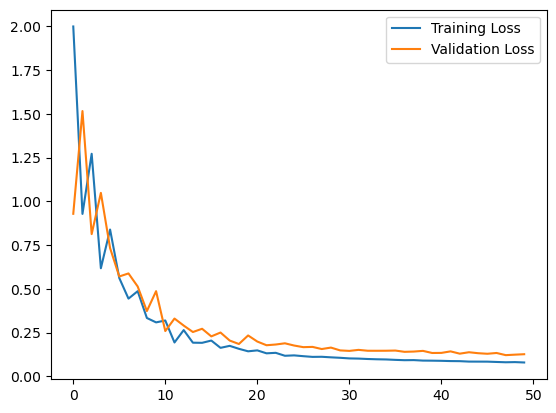

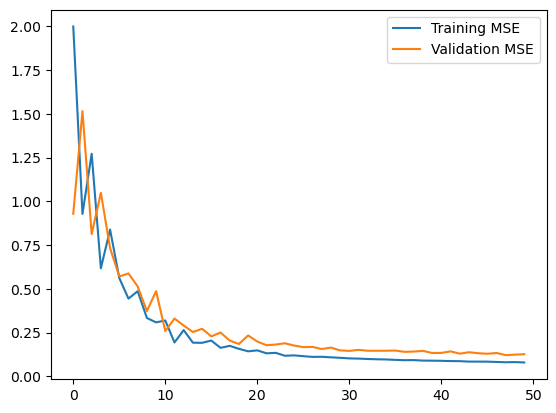

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0879 - mse: 0.0879 
Test Loss: 0.08408260345458984
Test MSE: 0.08408260345458984


In [27]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Funzione per costruire il modello (modificato per Keras Tuner)
def build_rbf_model_tuner(hp):
    input_dim = 12  # Numero di caratteristiche di input
    output_dim = 3  # Numero di target (x, y, z)

    n_centers = hp.Choice('n_centers', [25])
    gamma = hp.Choice('gamma', [0.1])
    learning_rate = hp.Choice('learning_rate', [0.5])
    batch_size = hp.Choice('batch_size', [75])

    # Crea il modello
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    # Layer RBF
    centers = tf.Variable(np.random.randn(n_centers, input_dim), dtype=tf.float32)
    model.add(layers.Lambda(lambda x: rbf_activation(x, centers, gamma)))  # Applica l'attivazione RBF

    # Layer di output
    model.add(layers.Dense(output_dim))

    # Ottimizzatore
    optimizer = Adam(learning_rate=learning_rate)

    # Compilazione del modello
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# Callback per visualizzare i progressi di ogni tentativo
class PrintTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss={logs['loss']}, Val_Loss={logs['val_loss']}")

# Tuner senza salvataggio dei risultati
tuner = kt.Hyperband(
    build_rbf_model_tuner,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    overwrite=True  # Evita di salvare i modelli e i risultati
)

# Esegui la ricerca con log dei progressi
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]  # Stampa i progressi
)

# Ottieni i migliori parametri
best_hp = tuner.get_best_hyperparameters()[0]
print(f"Migliori parametri: {best_hp.values}")

# Costruisci e addestra il modello con i migliori parametri
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=best_hp['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]
)

# Plot dei risultati
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.show()

 # Valutare il modello sui dati di test
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")


In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

# Funzione per costruire il modello (modificato per Keras Tuner)
def build_rbf_model_tuner(hp):
    input_dim = 12  # Numero di caratteristiche di input
    output_dim = 3  # Numero di target (x, y, z)

    n_centers = hp.Int('n_centers', min_value=20, max_value=30, step=5)
    gamma = hp.Float('gamma', min_value=0.1, max_value=1.0, step=0.5)
    learning_rate = hp.Float('learning_rate', min_value=0.00005, max_value=0.05, step=0.001)
    batch_size = hp.Int('batch_size', min_value=1, max_value=30, step=1)

    # Crea il modello
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    # Layer RBF
    centers = tf.Variable(np.random.randn(n_centers, input_dim), dtype=tf.float32)
    model.add(layers.Lambda(lambda x: rbf_activation(x, centers, gamma)))  # Applica l'attivazione RBF

    # Layer di output
    model.add(layers.Dense(output_dim))

    # Ottimizzatore
    optimizer = Adam(learning_rate=learning_rate)

    # Compilazione del modello
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# Callback per visualizzare i progressi di ogni tentativo
class PrintTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss={logs['loss']}, Val_Loss={logs['val_loss']}")

# Tuner senza salvataggio dei risultati
tuner = kt.Hyperband(
    build_rbf_model_tuner,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    overwrite=True  # Evita di salvare i modelli e i risultati
)

# Esegui la ricerca con log dei progressi
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]  # Stampa i progressi
)

# Ottieni i migliori parametri
best_hp = tuner.get_best_hyperparameters()[0]
print(f"Migliori parametri: {best_hp.values}")

# Costruisci e addestra il modello con i migliori parametri
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=best_hp['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]
)

# Plot dei risultati
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.show()

 # Valutare il modello sui dati di test
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
